In [134]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))

## 1. Load Dataset
---

In [143]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$cluster <- factor(data.df$cluster, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"cluster"]),]
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

### 2. Survival Curves
---

In [3]:
plotSurv <- function(fit, data.df, legend.title, legend.labs){
    p <- ggsurvplot(
        fit,                    
        data = data.df,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        xlab = "Time (Months)",
        break.time.by = 100,
        risk.table.y.text.col = T,
        risk.table.y.text = F,
        legend.title = legend.title,
        legend.labs = legend.labs,
    )
    
    return(p)
}

In [ ]:
fit <- survfit(Surv(time, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + BU.Cardiac.Stage, data=data.df)
plotSurv(fit, data.df, "BU Staging", c("AL"))

## 3. Cox Regressions
---

In [60]:
cox_model <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR  + BU.Cardiac.Stage, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_forest.pdf", plot = obj, width = 8, height = 10)

cox_model <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR  + BU.Cardiac.Stage + cluster, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_clust_forest.pdf", plot = obj, width = 7, height = 8)

cox_model <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR + BU.Cardiac.Stage + cluster4, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_clust4_forest.pdf", plot = obj, width = 7, height = 8)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [61]:
# Surv Object
time <- data.df$time_from_admission
status <- data.df$status
surv.obj <- Surv(time,status)

mod.1 <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + Primary_organ + BU.Cardiac.Stage, data = data.df)
mod.2 <- update(mod.1, . ~ . + cluster)
mod.3 <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + Primary_organ + cluster, data = data.df)

In [31]:
mod.1$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.805490e+05 6.787800e+04 0.000000e+00 7.900000e+01 0.000000e+00 7.267688e-01 
         std 
1.180510e-02

In [32]:
mod.2$concordance

concordant  discordant      tied.x      tied.y     tied.xy concordance 
1.81581e+05 6.68460e+04 0.00000e+00 7.90000e+01 0.00000e+00 7.30923e-01 
        std 
1.15854e-02

In [33]:
mod.3$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.768620e+05 7.268900e+04 0.000000e+00 7.900000e+01 0.000000e+00 7.087209e-01 
         std 
1.230158e-02

## 4. Adjusted Survival Curves
---

In [136]:
library(adjustedCurves)

In [173]:
vars.in.model <- c("LC.Isotype","Age","Sex","Race","Primary_organ",
                  "Era", "Troponin","eGFR","X24_hr_UTP","cluster","status","time_from_admission")


to.keep <- rownames(na.omit(data.df[,vars.in.model]))
fit <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race +
             Primary_organ + Era + Troponin + eGFR + X24_hr_UTP + Albumin + BU.Cardiaccluster, data = data.df[to.keep,], x=TRUE)


# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                       )

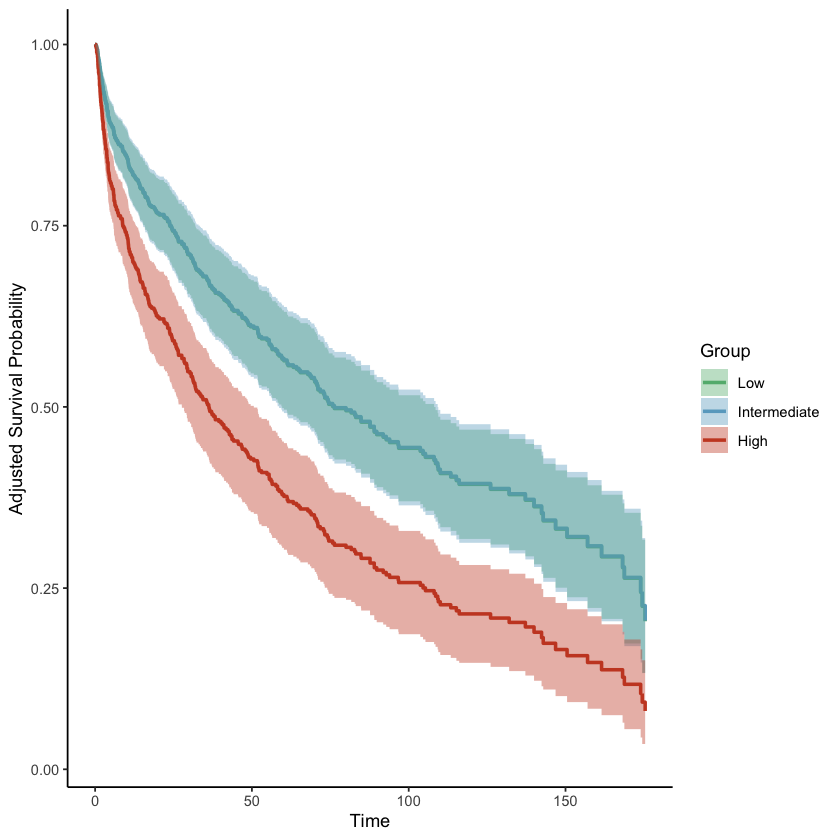

In [174]:
#pdf("figures/adjusted_surv_clust_bu.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
#dev.off()

In [179]:
vars.in.model <- c("LC.Isotype","Age","Sex","Race","Troponin","eGFR","Primary_organ",
                   "BU.Cardiac.Stage","cluster","status","time_from_admission")


to.keep <- rownames(na.omit(data.df[,vars.in.model]))
fit <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race +
             Primary_organ + Troponin + eGFR + cluster + BU.Cardiac.Stage, data = data.df[to.keep,], x=TRUE)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


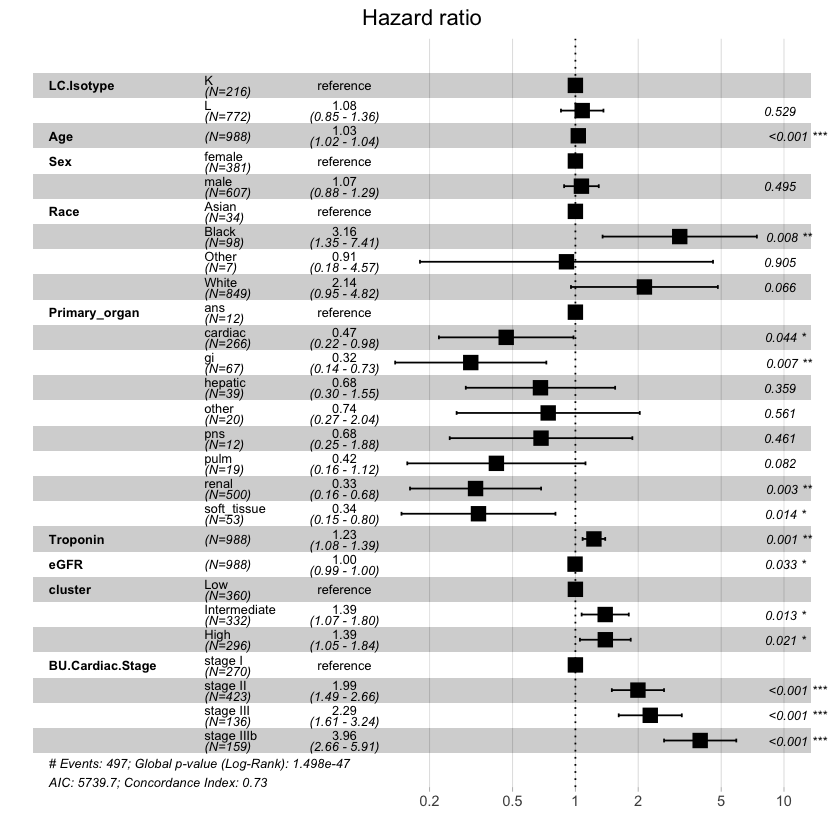

In [180]:
ggforest(fit)

In [159]:
# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                       )

pdf("figures/adjusted_surv_clust_bu.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
dev.off()

pdf 
  2

In [151]:
vars.in.model <- c("LC.Isotype","Age","Sex","Race","Primary_organ",
                  "Era","cluster","status","time_from_admission")


to.keep <- rownames(na.omit(data.df[,vars.in.model]))
fit <- coxph(Surv(time_from_admission, status) ~ LC.Isotype + Age + Sex + Race +
             Primary_organ + Era + cluster, data = data.df[to.keep,], x=TRUE)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


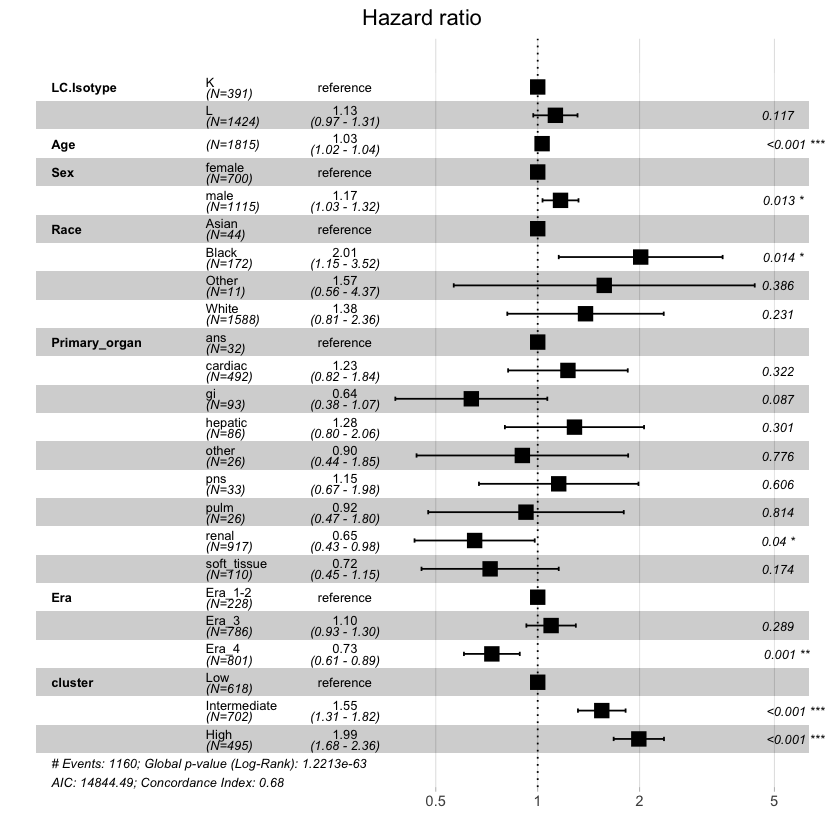

In [152]:
ggforest(fit)

In [155]:
# Adjusted survival curve without bootstrap
adjsurv <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                       )

pdf("figures/adjusted_surv_clust.pdf")
plot(adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"))
dev.off()

pdf 
  2

In [11]:
adjsurv.bootstrap <- adjustedsurv(data=data.df[to.keep,],
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=fit,
                        conf_int=TRUE,
                        n_cores=8,
                        n_boot=100,
                        bootstrap=TRUE
                       )

Loading required namespace: doParallel



In [12]:
adj_test <- adjusted_curve_test(adjsurv.bootstrap, from=0, to=150)
summary(adj_test)

------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 150 

                          ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value
Low vs. Intermediate  17.1406 5.8078         6.5413        29.6360    0.00
Low vs. High          30.2881 4.4528        19.5406        35.6767    0.00
Intermediate vs. High 13.1474 5.0916         2.2466        20.5027    0.01
                      N Boot
Low vs. Intermediate     100
Low vs. High             100
Intermediate vs. High    100
------------------------------------------------------------------


## 5. ESKD Logistic Regression
---

In [46]:
eskd.df <- read.table("data/processed/treatment_eskd.tsv", sep="\t", header=T, row.names="Code.ID")
data.df$eskd <- eskd.df[rownames(data.df),"treatment_eskd"]

In [73]:
log.mod <- glm(eskd ~ LC.Isotype + Age + Sex + Race + Troponin + BNP + X24_hr_UTP + Albumin +
             Primary_organ + Era + BU.Cardiac.Stage + cluster , family=binomial(link="logit"), data=data.df)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [74]:
summary(log.mod)


Call:
glm(formula = eskd ~ LC.Isotype + Age + Sex + Race + Troponin + 
    BNP + X24_hr_UTP + Albumin + Primary_organ + Era + BU.Cardiac.Stage + 
    cluster, family = binomial(link = "logit"), data = data.df)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                -1.809e+01  3.997e+03  -0.005  0.99639   
LC.IsotypeL                -6.312e-01  2.713e-01  -2.327  0.01999 * 
Age                        -1.367e-02  1.218e-02  -1.123  0.26154   
Sexmale                     9.512e-02  2.387e-01   0.398  0.69027   
RaceBlack                   9.416e-02  7.599e-01   0.124  0.90138   
RaceOther                  -2.889e-01  1.416e+00  -0.204  0.83830   
RaceWhite                   2.855e-02  6.772e-01   0.042  0.96638   
Troponin                   -2.451e-01  5.088e-01  -0.482  0.62998   
BNP                         2.907e-04  2.603e-04   1.117  0.26407   
X24_hr_UTP                  3.373e-05  2.891e-05   1.167  0.24337   
Albumin        

In [99]:
log.mod <- glm(eskd ~ LC.Isotype + Age + Race + Sex + Primary_organ + cluster*eGFR + 
               cluster*X24_hr_UTP + cluster*Albumin, family=binomial(link="logit"), data=data.df)

summary(log.mod)


Call:
glm(formula = eskd ~ LC.Isotype + Age + Race + Sex + Primary_organ + 
    cluster * eGFR + cluster * X24_hr_UTP + cluster * Albumin, 
    family = binomial(link = "logit"), data = data.df)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     4.545e+00  1.924e+00   2.362   0.0182 *  
LC.IsotypeL                    -3.496e-01  2.142e-01  -1.632   0.1028    
Age                            -5.143e-02  8.777e-03  -5.859 4.65e-09 ***
RaceBlack                      -2.789e-03  6.635e-01  -0.004   0.9966    
RaceOther                       3.536e-01  1.211e+00   0.292   0.7702    
RaceWhite                       3.963e-01  5.953e-01   0.666   0.5056    
Sexmale                         2.805e-01  1.777e-01   1.579   0.1144    
Primary_organcardiac           -5.553e-01  7.297e-01  -0.761   0.4466    
Primary_organgi                 1.743e-01  8.739e-01   0.199   0.8419    
Primary_organhepatic           -2.104e+00  1.227e